In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline

In [2]:
dataset = pd.read_excel('../dataset/ocean_prepared_dataset.xlsx')

In [3]:
dataset

,O,C,E,A,N,ID,Message
0,163,254,318,452,251,12373,"I can morning. i'm Okay, how are you. that's a..."
1,85,158,196,292,275,5197,i'm doing good give me a. Second. yeah I can h...
2,13,17,13,20,7,7906,morning. Barely good one are barely. that's al...
3,87,124,168,229,274,2064,"How are you. How. A lot a lot Oh, she got the ..."
4,27,39,43,65,67,17043,yeah I went to that page and I don't know what...
...,...,...,...,...,...,...,...
621,48,90,121,179,57,12800,Hello. Good how are you. Not much has happened...
622,145,253,320,472,294,12622,"There we go. i'm all right, I think I need to ..."
623,116,180,214,322,333,13557,Can you hear me. I know just confused I. yeah ...
624,99,156,203,286,254,12722,Hello it's morning. You thought for sure I was...


In [4]:
Messages = dataset['Message']

In [5]:
Messages

0      I can morning. i'm Okay, how are you. that's a...
1      i'm doing good give me a. Second. yeah I can h...
2      morning. Barely good one are barely. that's al...
3      How are you. How. A lot a lot Oh, she got the ...
4      yeah I went to that page and I don't know what...
                             ...                        
621    Hello. Good how are you. Not much has happened...
622    There we go. i'm all right, I think I need to ...
623    Can you hear me. I know just confused I. yeah ...
624    Hello it's morning. You thought for sure I was...
625    around like the first week of September I star...
Name: Message, Length: 626, dtype: object

In [6]:
ocean = dataset.drop(columns=['Message','ID'])

In [7]:
ocean.head()

,O,C,E,A,N
0,163,254,318,452,251
1,85,158,196,292,275
2,13,17,13,20,7
3,87,124,168,229,274
4,27,39,43,65,67


In [8]:
vectorizer = TfidfVectorizer(max_features=512)  # Use TF-IDF to convert text to embeddings
X = vectorizer.fit_transform(Messages)

In [9]:
X.shape

(626, 512)

In [10]:
y = ocean.values
scaler = MinMaxScaler()
y = scaler.fit_transform(y)

In [11]:
def scale_back(scaler:MinMaxScaler,vector):
    return scaler.inverse_transform(vector.reshape(1,-1))

In [12]:
y.shape

(626, 5)

In [13]:
pca = PCA(n_components=3)
y_reduced = pca.fit_transform(y)

In [14]:
tuned_params = {
    'objective': 'reg:squarederror',
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'n_estimators': 100
}
xgb_model = MultiOutputRegressor(XGBRegressor(**tuned_params))

In [15]:
pipeline = Pipeline([
    ('vectorizer', vectorizer),          # Step 1: Text vectorization
    ('regressor', xgb_model)             # Step 2 & 3: Multi-output regression
])

In [16]:
pipeline.fit(Messages, y_reduced)

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=512)),
                ('regressor',
                 MultiOutputRegressor(estimator=XGBRegressor(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=0.8,
                                                             device=None,
                                                             early_stopping_rounds=None,
                                                             enable_categorical=False,
                                                             eta=0.1,
                                                             eval_metric=None,
                                                             feature_types=None,
                                                             gamma=None,
                                                             grow_policy=None,
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=None,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=6,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=100,
                                                             n_jobs=None,
                                                             num_parallel_tree=None, ...)))])

In [17]:
def predict_traits(id,input_text):
    y_pred_reduced = pipeline.predict([input_text])
    y_pred_full = pca.inverse_transform(y_pred_reduced)[0]
    y_pred_full = np.array([float(score) for score in y_pred_full])
    trait_names = list(ocean.columns) + ['ID','Message']
    trait_dict = dict(zip(trait_names, [round(float(trait),4) for trait in scale_back(scaler,y_pred_full)[0]] +[id,input_text] ))
    return trait_dict,scale_back(scaler,y_pred_full)

In [18]:
scores = []
output = []
for index,row in dataset.iterrows():
    input_text = row['Message']
    predicted_traits,y_out = predict_traits(row['ID'],input_text)
    score = r2_score(scale_back(scaler,y[index])[0],y_out[0])
    scores.append(score)
    output.append(predicted_traits)

In [19]:
pd.DataFrame(output).to_excel('OceanOutput.xlsx',index=False)

In [20]:
from matplotlib import pyplot as plt
import seaborn as sns

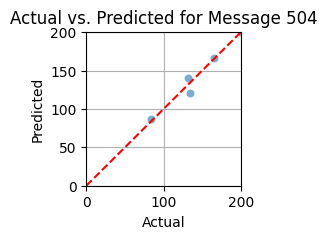

In [26]:
trait_index = 503
input = Messages[trait_index]
idp = dataset['ID'][trait_index]
predicted_traits,y_out = predict_traits(idp,input)

df = pd.DataFrame({
    'Actual': scale_back(scaler,y[trait_index])[0],
    'Predicted': y_out[0]
})

# Create the scatter plot using Seaborn
plt.figure(figsize=(2, 2))
sns.scatterplot(data=df, x='Actual', y='Predicted', alpha=0.6)

# Add a line for perfect prediction
max_value = max(df['Actual'].max(), df['Predicted'].max())
plt.plot([0, max_value], [0, max_value], 'r--')  # Line for perfect prediction

plt.title(f'Actual vs. Predicted for Message {trait_index + 1}')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.xlim(0, max_value)
plt.ylim(0, max_value)
plt.grid(True)
plt.show()

In [ ]:
import joblib
joblib.dump(pipeline, 'ocean_pipeline.pkl')

['ocean_pipeline.pkl']

In [54]:
predict_traits(dataset['ID'][0],dataset['Message'][0])

({'O': 164.1099,
  'C': 249.9236,
  'E': 318.8507,
  'A': 455.429,
  'N': 251.4075,
  'ID': np.int64(12373),
  'Message': "I can morning. i'm Okay, how are you. that's amazing i'm really happy for you. Oh yeah oh that's really nice. The weather and everything. I mean I, how can I ask for anything nicer. i'm not good not good at all. So i'm. My new therapist suggested that I get on medication or I talk to you about medication for. My Depression and anxiety. cymbalta helps with my anxiety a bit didn't really do anything for my depression and I was taking wellbutrin. For a very long time, I think. And it did work for a while. i've tried lexapro I didn't really like it because I sort of. I don't remember. The six months that I was on it, I just I guess was a robot during that time, but. I don't i'm not. opposed to it, those are just the ones that i've experienced and taken in terms of antidepressants and anti anxiety. i'm having anxiety attacks that last. More than. about an hour hour and 

In [56]:
import plotly.graph_objects as go
import numpy as np

def plot_spider_chart_plotly(scores):
    traits = list(scores.keys())
    trait_scores = list(scores.values())
    
    # Add the first value to the end to close the chart
    traits += traits[:1]
    trait_scores += trait_scores[:1]
    
    # Create radar chart
    fig = go.Figure()
    fig.add_trace(go.Scatterpolar(
        r=trait_scores,
        theta=traits,
        fill='toself',
        name='Traits',
        line=dict(color='blue')
    ))
    
    # Customize layout
    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 1]  # Assuming scores are normalized between 0 and 1
            )
        ),
        showlegend=False,
        title="Spider Chart for Predicted Scores"
    )
    
    fig.show()

# Example usage with predicted scores
predicted_scores = {
    "Openness": 0.8,
    "Conscientiousness": 0.6,
    "Extraversion": 0.7,
    "Agreeableness": 0.9,
    "Neuroticism": 0.4
}

plot_spider_chart_plotly(predicted_scores)
